In [52]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [53]:
train = pd.read_csv('SpotifyAudioFeaturesNov2018.csv')
test = pd.read_csv('SpotifyAudioFeaturesApril2019.csv')

In [54]:
train.head()

,artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
0,YG,2RM4jf1Xa9zPgMGRDiht8O,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",0.005820,0.743,238373,0.339,0.000,1,0.0812,-7.678,1,0.4090,203.927,4,0.118,44
1,YG,1tHDG53xJNGsItRA3vfVgs,BAND DRUM (feat. A$AP Rocky),0.024400,0.846,214800,0.557,0.000,8,0.2860,-7.259,1,0.4570,159.009,4,0.371,10
2,R3HAB,6Wosx2euFPMT14UXiWudMy,Radio Silence,0.025000,0.603,138913,0.723,0.000,9,0.0824,-5.890,0,0.0454,114.966,4,0.382,63
3,Chris Cooq,3J2Jpw61sO7l6Hc7qdYV91,Lactose,0.029400,0.800,125381,0.579,0.912,5,0.0994,-12.118,0,0.0701,123.003,4,0.641,9
4,Chris Cooq,2jbYvQCyPgX3CdmAzeVeuS,Same - Original mix,0.000035,0.783,124016,0.792,0.878,7,0.0332,-10.277,1,0.0661,120.047,4,0.928,8


In [55]:
train.drop(['artist_name', 'track_id', 'track_name'], inplace=True, axis=1)
test.drop(['artist_name', 'track_id', 'track_name'], inplace=True, axis=1)

In [56]:
train.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
0,0.005820,0.743,238373,0.339,0.000,1,0.0812,-7.678,1,0.4090,203.927,4,0.118,44
1,0.024400,0.846,214800,0.557,0.000,8,0.2860,-7.259,1,0.4570,159.009,4,0.371,10
2,0.025000,0.603,138913,0.723,0.000,9,0.0824,-5.890,0,0.0454,114.966,4,0.382,63
3,0.029400,0.800,125381,0.579,0.912,5,0.0994,-12.118,0,0.0701,123.003,4,0.641,9
4,0.000035,0.783,124016,0.792,0.878,7,0.0332,-10.277,1,0.0661,120.047,4,0.928,8


In [57]:
train = train.sample(10000, axis=0)
train.shape

(10000, 14)

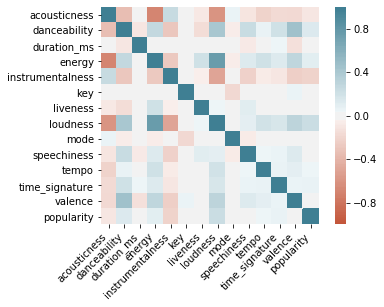

In [70]:
corr = train.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [58]:
X_train = train.iloc[:, 0:13]
y_train = train.iloc[:, 13]
X_test = train.iloc[:, 0:13]
y_test = train.iloc[:, 13]

In [59]:
key = pd.get_dummies(X_train['key'], prefix='key')
time_signature = pd.get_dummies(X_train['time_signature'], prefix='time_signature')
X_train = pd.concat([X_train, key, time_signature], axis=1)
X_train.drop(['key', 'time_signature'], inplace=True, axis=1)

key = pd.get_dummies(X_test['key'], prefix='key')
time_signature = pd.get_dummies(X_test['time_signature'], prefix='time_signature')
X_test = pd.concat([X_test, key, time_signature], axis=1)
X_test.drop(['key', 'time_signature'], inplace=True, axis=1)

In [60]:
X_train.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,...,key_7,key_8,key_9,key_10,key_11,time_signature_0,time_signature_1,time_signature_3,time_signature_4,time_signature_5
15141,0.71800,0.327,263424,0.519,0.000000,0.1080,-6.347,1,0.0338,80.554,...,0,0,0,0,0,0,0,1,0,0
37678,0.08300,0.876,138150,0.629,0.462000,0.0622,-3.876,0,0.1230,140.031,...,0,0,0,0,0,0,0,0,1,0
24674,0.00436,0.637,128000,0.782,0.004670,0.4120,-12.518,1,0.1040,165.039,...,0,0,0,0,0,0,0,0,1,0
189,0.37900,0.735,186667,0.819,0.000000,0.0423,-4.809,1,0.1240,90.039,...,0,0,0,0,0,0,0,0,1,0
26641,0.01780,0.751,192097,0.958,0.000006,0.7920,-3.312,0,0.1190,124.004,...,0,0,1,0,0,0,0,0,1,0


In [61]:
X_train.shape

(10000, 28)

In [68]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

knn = Pipeline([
    #('std', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

grid = [
    {'knn__n_neighbors': range(5, 10)}
]

svm_gs = GridSearchCV(knn, grid, scoring='f1_micro', cv=5, n_jobs=-1)
svm_gs.fit(X_train, y_train)

/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'knn__n_neighbors': range(5, 10)}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=0)

In [69]:
pd.DataFrame(svm_gs.cv_results_).sort_values('rank_test_score').head(1)

/usr/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
3,0.02187,0.001466,0.098317,0.004211,8,{'knn__n_neighbors': 8},0.062714,0.053492,0.055556,0.050531,...,0.0567,0.004594,1,0.198392,0.196091,0.194201,0.19985,0.191116,0.19593,0.003086


In [ ]:
from sklearn.ensemble import RandomForestClassifier